In [1]:
# Main import block 
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import random
import itertools
import time
from sklearn.calibration import Parallel, delayed
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.base import clone
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:

# Import data and show shapes
try:
    train_df = pd.read_csv('train_motion_data.csv')
    test_df = pd.read_csv('test_motion_data.csv')
    print("Train and test data loaded successfully.")
    print(f"Training data shape: {train_df.shape}")
    print(f"Testing data shape: {test_df.shape}\n")
except FileNotFoundError:
    print("Error: Make sure 'train_motion_data.csv' and 'test_motion_data.csv' are in the same directory.")
    exit()

train_df

print(f"Original shape: {train_df.shape}")

Train and test data loaded successfully.
Training data shape: (3644, 8)
Testing data shape: (3084, 8)

Original shape: (3644, 8)


As we can see, our training and testing data is of a similar size which will be useful when predicting our models and measuring accuracy. 

In [3]:
# Define features (X) and target (y)
features = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
target = 'Class'

# Get train and test subsets 
X_train = train_df[features]
y_train_labels = train_df[target]
X_test = test_df[features]
y_test_labels = test_df[target]

# Encode labels into numbers that can be processed by various ML models.
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# scale X training data only to ensure data is within similar values 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now All of our data is scaled, encoded and ready to use! Time to start testing different models!

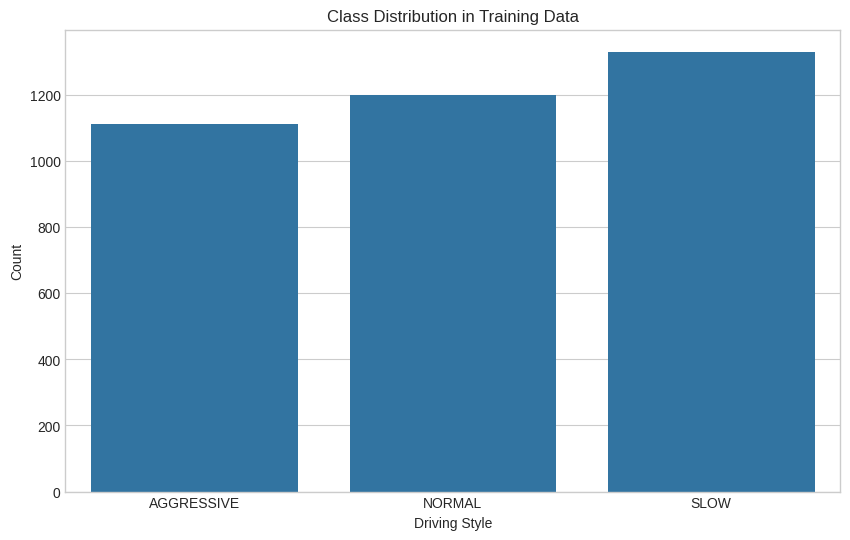

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_labels, order=le.classes_)
plt.title('Class Distribution in Training Data')
plt.xlabel('Driving Style')
plt.ylabel('Count')
plt.show()

The distribution of our output features are pretty similar. 

In [4]:
# create result grid to store classification results 
results = {}

# This function runs a parallel grid search on the given model, using the given parameter grid, ranking on test accuracy. 
# This is important for this dataset because overfitting to the training set happens easily and we want to measure
# the best test accuracy possible. 
def run_grid_search(model, param_grid, X_train, y_train, X_test, y_test):

    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"Testing {len(param_combinations)} candidate models...")
    print("-" * 80)

    # Trains a single model and evaluates it on the test set.
    def evaluate_candidate(params, X_train, y_train, X_test, y_test):
        # model = RandomForestClassifier(random_state=42, n_jobs=1, **params)

        candidate_model = clone(model)
        candidate_model.set_params(**params)
        
        # Train
        candidate_model.fit(X_train, y_train)
        
        # Predict
        predictions = candidate_model.predict(X_test)
        acc = accuracy_score(y_test, predictions)
        
        # Return dictionary of results
        result = params.copy()
        result['test_accuracy'] = acc
        return result
    
    start_time = time.time()


    results = Parallel(n_jobs=-1, verbose=1)(
    delayed(evaluate_candidate)(params, X_train, y_train, X_test, y_test)
    for params in param_combinations
    )

    end_time = time.time()
    print(f"\nGrid Search completed in {end_time - start_time:.2f} seconds.")
    time.sleep(1)

    results_df = pd.DataFrame(results)

    # Sort by Test Accuracy (Descending)
    best_model = results_df.sort_values(by='test_accuracy', ascending=False).iloc[0]

    print("\n" + "="*40)
    print("       WINNING MODEL FOUND")
    print("="*40)
    print(f"Best Test Accuracy: {best_model['test_accuracy']:.4f}")
    print("-" * 40)
    for key, value in best_model.items():
        if key == 'test_accuracy':
            continue
        print(f"{key}: {value}")
    print("-" * 40)

    test_accuracy = best_model['test_accuracy']
    best_params = best_model.drop('test_accuracy').to_dict()

    best_params = {
    k: int(v) if isinstance(v, float) and v.is_integer() else v 
    for k, v in best_params.items()
    }
    
    # 2. Create a fresh model with the winning settings
    final_model = clone(model)
    final_model.set_params(**best_params)
    
    # 3. Retrain on the full training set
    final_model.fit(X_train, y_train)
    
    # 4. Predict and Report
    final_predictions = final_model.predict(X_test)


    model_name = type(model).__name__
    print("\n" + "="*60)
    print("                     CLASSIFICATION REPORT")
    print("="*60)
    report_str = classification_report(y_test, final_predictions)
    report_dict = classification_report(y_test, final_predictions, output_dict=True)
    report_dict['test_accuracy'] = test_accuracy
    print(report_str)

    return model_name, report_dict 
    

In [37]:
# KNN Test:

knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2],  # Only relevant if metric is 'minkowski'
    'leaf_size': [10, 30, 50]
}

print("RUNNING GRID SEARCH ON KNN CLASSIFIER MODEL")
name, report = run_grid_search(knn_model,param_grid,X_train,y_train,X_test,y_test)

results[name] = report

RUNNING GRID SEARCH ON KNN CLASSIFIER MODEL
Testing 180 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    9.6s finished



Grid Search completed in 9.65 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4053
----------------------------------------
n_neighbors: 11
weights: distance
metric: minkowski
p: 2
leaf_size: 50
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.40      0.34      0.37       814
           1       0.33      0.31      0.32       997
           2       0.46      0.52      0.49      1273

    accuracy                           0.41      3084
   macro avg       0.40      0.39      0.39      3084
weighted avg       0.40      0.41      0.40      3084



In [38]:

# Gradient Boosting Classifier Test: 
gb_model = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.01, 0.2], 
    'max_depth': [3, 4], 
    'subsample': [0.7], 
    'min_samples_split': [2, 10],  
    'min_samples_leaf': [1, 4],  
    'max_features': ['sqrt'] 
}

print("RUNNING GRID SEARCH ON GRADIENT BOOSTING CLASSIFIER MODEL")
name, report = run_grid_search(gb_model,param_grid,X_train,y_train,X_test,y_test)

results[name] = report

RUNNING GRID SEARCH ON GRADIENT BOOSTING CLASSIFIER MODEL
Testing 32 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   11.9s finished



Grid Search completed in 11.90 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4705
----------------------------------------
n_estimators: 100
learning_rate: 0.01
max_depth: 3
subsample: 0.7
min_samples_split: 2
min_samples_leaf: 1
max_features: sqrt
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.49      0.33      0.39       814
           1       0.32      0.04      0.07       997
           2       0.47      0.89      0.61      1273

    accuracy                           0.47      3084
   macro avg       0.43      0.42      0.36      3084
weighted avg       0.43      0.47      0.38      3084



In [39]:
# Bagging Classifier Test: 

bag_model = BaggingClassifier()

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap_features': [True, False]
}

print("RUNNING GRID SEARCH ON BAGGING CLASSIFIER MODEL")
name, report = run_grid_search(bag_model,param_grid,X_train,y_train,X_test,y_test)

results[name] = report

RUNNING GRID SEARCH ON BAGGING CLASSIFIER MODEL
Testing 54 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   13.0s finished



Grid Search completed in 12.98 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4283
----------------------------------------
n_estimators: 100
max_samples: 0.5
max_features: 1.0
bootstrap_features: False
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.33      0.27      0.30       814
           1       0.31      0.32      0.32       997
           2       0.44      0.48      0.46      1273

    accuracy                           0.37      3084
   macro avg       0.36      0.36      0.36      3084
weighted avg       0.37      0.37      0.37      3084



In [40]:
# Hist Graident Boosting Classifier Test: 

hgb_model = HistGradientBoostingClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_leaf_nodes': [20, 31, 50, 100],
    'max_iter': [100, 200, 500],
    'l2_regularization': [0.0, 0.1, 1.0],
    'max_bins': [63, 127, 255]
}

print("RUNNING GRID SEARCH ON HIST GRADIENT BOOSTING CLASSIFIER MODEL")
name, report = run_grid_search(hgb_model,param_grid,X_train,y_train,X_test,y_test)
results[name] = report

RUNNING GRID SEARCH ON HIST GRADIENT BOOSTING CLASSIFIER MODEL
Testing 432 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s


KeyboardInterrupt: 

In [ ]:
# Try MLPClassifier

mlp_model = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(50, 50), (100), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.05],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200, 300]
}

print("RUNNING GRID SEARCH ON MLP CLASSIFIER MODEL")
name, report = run_grid_search(mlp_model,param_grid,X_train,y_train,X_test,y_test)
results[name] = report

RUNNING GRID SEARCH ON MLP CLASSIFIER MODEL
Testing 96 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opt


Grid Search completed in 20.41 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4640
----------------------------------------
hidden_layer_sizes: 100
activation: tanh
solver: sgd
alpha: 0.0001
learning_rate_init: 0.001
max_iter: 200
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.50      0.25      0.33       814
           1       0.39      0.06      0.11       997
           2       0.46      0.90      0.61      1273

    accuracy                           0.46      3084
   macro avg       0.45      0.40      0.35      3084
weighted avg       0.45      0.46      0.37      3084



In [45]:
# Try AdaBoostClassifier

ada_model = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

print("RUNNING GRID SEARCH ON ADA BOOST CLASSIFIER MODEL")
name, report = run_grid_search(ada_model,param_grid,X_train,y_train,X_test,y_test)
results[name] = report

RUNNING GRID SEARCH ON ADA BOOST CLASSIFIER MODEL
Testing 15 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

As we can see, our accuracy hovers around 40%, with f1 scores and precision that is not much better. Why is this? Well, it is seemingly quite difficult to not overfit our data and at the same time get good idea of the trend of the testing data. To combat this we can try a sliding window technique. We will loop through our dataset, looking at values from n to n+window_size. For each of these rows inside the window, we will calculate mean, standard deviation, min and max for each feature. This will allow us to see more trends and hopefully create a more accurate model. 

In [5]:
WINDOW_SIZE = 150

# Function to create a dataframe from the original data using a sliding window 
def create_time_series_features(df, feature_cols, window_size):
    """
    Creates time-series features based on a rolling window.
    """
    df_sorted = df.sort_values(by=timestamp_col).copy()

    df_out = df_sorted[[timestamp_col, target_col]].copy()

    for col in feature_cols:
        df_out[f'{col}_mean_{window_size}'] = df_sorted[col].rolling(window=window_size).mean()
        df_out[f'{col}_std_{window_size}'] = df_sorted[col].rolling(window=window_size).std()
        df_out[f'{col}_max_{window_size}'] = df_sorted[col].rolling(window=window_size).max()
        df_out[f'{col}_min_{window_size}'] = df_sorted[col].rolling(window=window_size).min()
    df_out = df_out.dropna()

    return df_out

feature_cols = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
target_col = 'Class'
timestamp_col = 'Timestamp'

# Creates 'engineered' datasets using sliding window technique 
df_train_engineered = create_time_series_features(train_df, feature_cols, WINDOW_SIZE)
df_test_engineered = create_time_series_features(test_df,feature_cols, WINDOW_SIZE)

# Define features (X) and target (y)
features = df_train_engineered.columns.to_list();
features.remove('Class')
target = 'Class'

# Get train and test subsets 
X_train = df_train_engineered[features]
y_train_labels = df_train_engineered[target]
X_test = df_test_engineered[features]
y_test_labels = df_test_engineered[target]

# Encode labels into numbers that can be processed by various ML models.
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# scale X training data only to ensure data is within similar values 
scaler = StandardScaler()
X_train_eng = scaler.fit_transform(X_train)
X_test_eng = scaler.transform(X_test)



In [43]:
# Try KNN again with new 'eng' engineered values 

knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11,20,50,100,150,500],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2],
    'leaf_size': [10, 30, 50]
}

print("RUNNING GRID SEARCH ON KNN CLASSIFIER MODEL")
name, report = run_grid_search(knn_model,param_grid,X_train_eng,y_train,X_test_eng,y_test)
results[name + '_eng'] = report

RUNNING GRID SEARCH ON KNN CLASSIFIER MODEL
Testing 360 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: Found input variables with inconsistent numbers of samples: [3495, 3644]

In [6]:
# Try random forest with new 'eng' engineered values 

rf_model = RandomForestClassifier(random_state=42)  

param_grid = {
    'n_estimators': [710],
    'max_depth': [4],
    'min_samples_leaf': [734],
    'min_samples_split': [2],
    'criterion': ['gini'],
    'max_features': ['sqrt']
}

print("RUNNING GRID SEARCH ON RANDOM FOREST CLASSIFIER MODEL")
name, report = run_grid_search(rf_model,param_grid,X_train_eng,y_train,X_test_eng,y_test)
results[name + '_eng'] = report


RUNNING GRID SEARCH ON RANDOM FOREST CLASSIFIER MODEL
Testing 1 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Grid Search completed in 2.34 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.7019
----------------------------------------
n_estimators: 710
max_depth: 4
min_samples_leaf: 734
min_samples_split: 2
criterion: gini
max_features: sqrt
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.63      0.97      0.76       665
           1       0.69      0.50      0.58       997
           2       0.77      0.72      0.75      1273

    accuracy                           0.70      2935
   macro avg       0.70      0.73      0.70      2935
weighted avg       0.71      0.70      0.69      2935



Training the best Random Forest model with the specified parameters...
Model training complete.
Best Model Log Loss: 0.8960320423644357

Test Accuracy of the Best Model: 0.7019


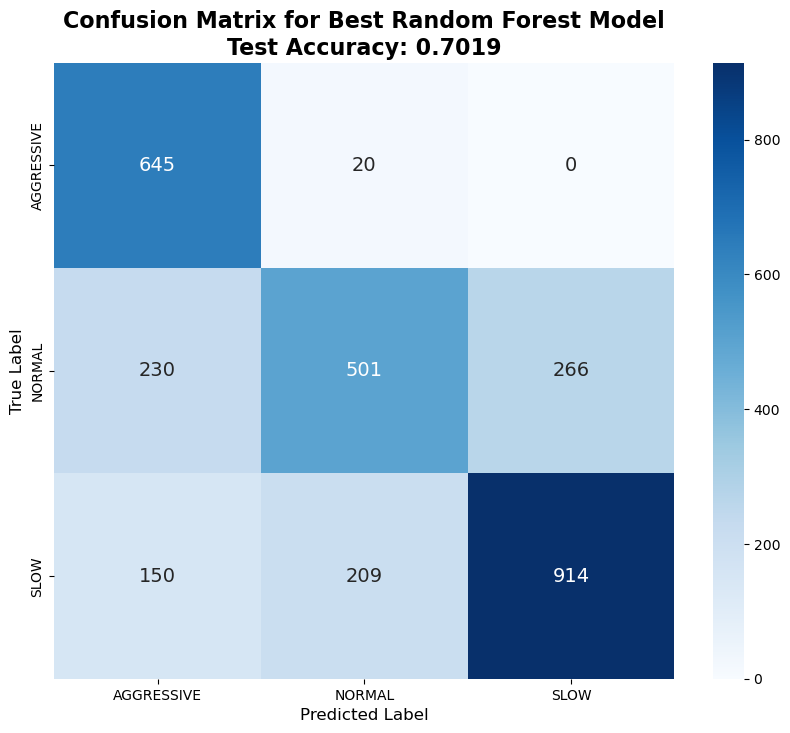

In [7]:
best_params = {
    'n_estimators': 710,
    'max_depth': 4,
    'min_samples_leaf': 734,
    'min_samples_split': 2,
    'criterion': 'gini',
    'max_features': 'sqrt',
    'random_state': 42 
}

print("Training the best Random Forest model with the specified parameters...")
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_eng, y_train)
print("Model training complete.")

from sklearn.metrics import log_loss


y_proba = best_rf_model.predict_proba(X_test_eng)
loss = log_loss(y_test, y_proba)

print("Best Model Log Loss:", loss)


# Make predictions on the engineered test data
y_pred = best_rf_model.predict(X_test_eng)

# Calculate the accuracy score
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy of the Best Model: {test_accuracy:.4f}")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the class names from the LabelEncoder
class_names = le.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 14})

# Add accuracy score to the title
title = f'Confusion Matrix for Best Random Forest Model\nTest Accuracy: {test_accuracy:.4f}'
plt.title(title, fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


In [ ]:

# rerun gradient boosting model to see if we get better results
gb_model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.1, 0.2], 
    'max_depth': [3, 4],  
    'subsample': [0.7, 1.0],  
    'min_samples_split': [2, 10], 
    'min_samples_leaf': [1, 4],  
    'max_features': ['sqrt', 'log2', None] 
}

name, report = run_grid_search(gb_model,param_grid,X_train_eng,y_train,X_test_eng,y_test)
results[name + '_eng'] = report



Testing 192 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   28.3s finished



Grid Search completed in 28.27 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.5284
----------------------------------------
n_estimators: 100
learning_rate: 0.1
max_depth: 3
subsample: 1.0
min_samples_split: 10
min_samples_leaf: 1
max_features: log2
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       665
           1       0.41      0.89      0.56       997
           2       1.00      0.14      0.24      1273

    accuracy                           0.53      2935
   macro avg       0.74      0.59      0.53      2935
weighted avg       0.76      0.53      0.47      2935



In [ ]:
# rerun bagging to see if we get better results

bag_model = BaggingClassifier()

param_grid = {
    'n_estimators': [10, 50, 100, 150],
    'max_samples': [0.25, 0.5, 0.75, 1.0,50],
    'max_features': [0.1, 0.25, 0.5, 0.75, 1.0],
    'bootstrap_features': [True, False]
}

print("RUNNING GRID SEARCH ON BAGGING CLASSIFIER MODEL")
name, report = run_grid_search(bag_model,param_grid,X_train_eng,y_train,X_test_eng,y_test)
results[name + '_eng'] = report



RUNNING GRID SEARCH ON BAGGING CLASSIFIER MODEL
Testing 200 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished



Grid Search completed in 4.42 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.6876
----------------------------------------
n_estimators: 100
max_samples: 0.5
max_features: 0.25
bootstrap_features: False
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       665
           1       0.45      0.56      0.50       997
           2       0.75      0.54      0.63      1273

    accuracy                           0.62      2935
   macro avg       0.64      0.65      0.64      2935
weighted avg       0.65      0.62      0.62      2935



As we can see, using the sliding window technique significantly improves accuracy and f1 scores by about 20-30 percent. The best performing model we were able to find was the Random Forest Classifier model with the following parameters: 

Random Forest Classifier:
Test Accuracy: 0.7019
n_estimators: 710
max_depth: 4
min_samples_leaf: 734
min_samples_split: 2.0
criterion: gini
max_features: sqrt

Below are plots showing our results 

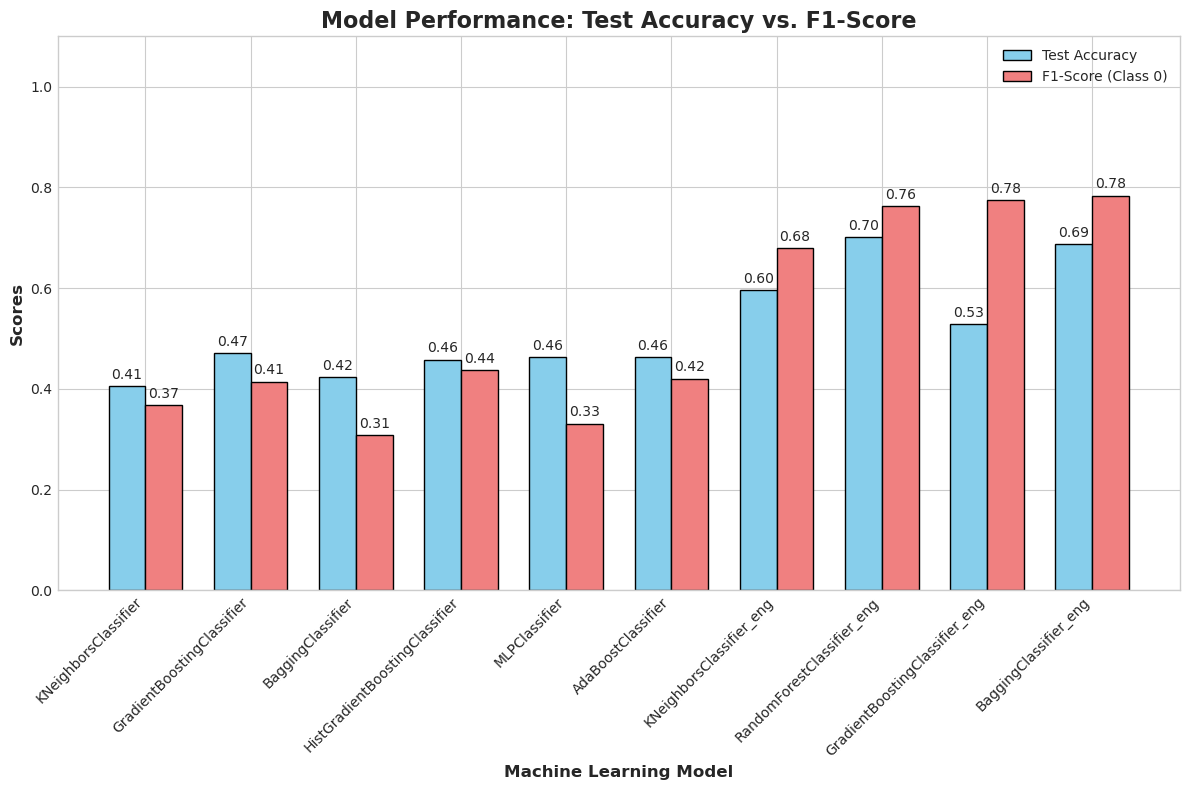

In [ ]:

model_names = list(results.keys())
test_accuracies = [results[model]['test_accuracy'] for model in model_names]
f1_scores = [results[model]['0']['f1-score'] for model in model_names]


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))


x = np.arange(len(model_names))  
width = 0.35 

# Create the bars for test accuracy
rects1 = ax.bar(x - width/2, test_accuracies, width, label='Test Accuracy', color='skyblue', edgecolor='black')

# Create the bars for F1-score
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score (Class 0)', color='lightcoral', edgecolor='black')

# 4. Add labels, title, and legend
ax.set_xlabel('Machine Learning Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Scores', fontsize=12, fontweight='bold')
ax.set_title('Model Performance: Test Accuracy vs. F1-Score', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Set the y-axis limit
ax.set_ylim(0, 1.1) 

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


/tmp/ipykernel_194480/886735251.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='f1-score', y='model', data=accuracy_df, palette='viridis')


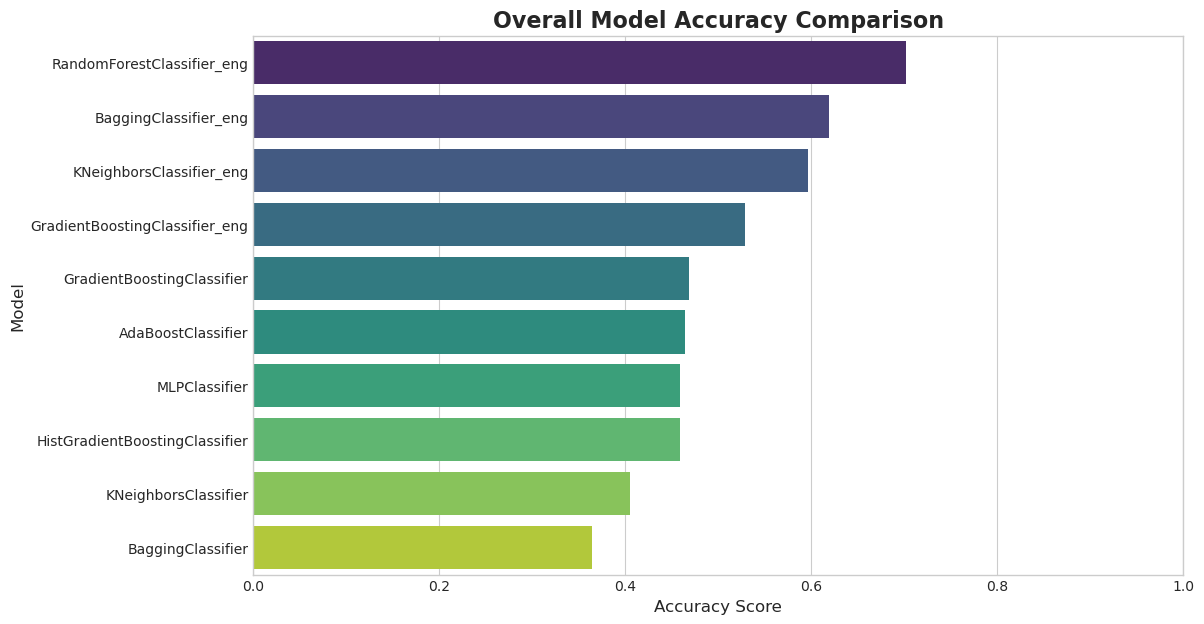

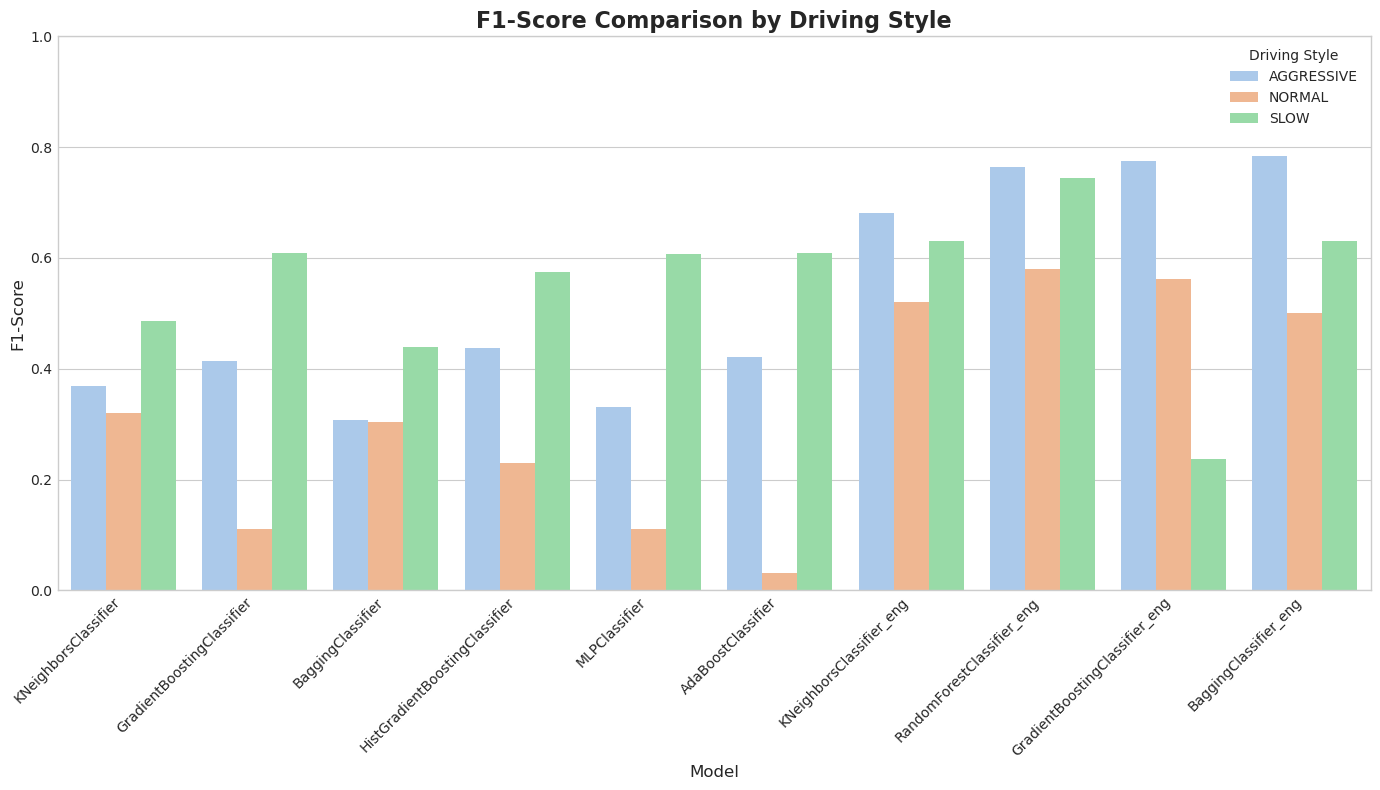

In [ ]:
class_names = le.classes_ 

plot_data = []
for model_name, report in results.items():

    plot_data.append({
        'model': model_name,
        'class': 'Overall',
        'f1-score': report['accuracy'],
        'metric': 'Accuracy'
    })

    for class_idx, class_name in enumerate(class_names):
        plot_data.append({
            'model': model_name,
            'class': class_name,
            'f1-score': report[str(class_idx)]['f1-score'],
            'metric': 'F1-Score'
        })

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 7))
accuracy_df = plot_df[plot_df['metric'] == 'Accuracy'].sort_values('f1-score', ascending=False)
sns.barplot(x='f1-score', y='model', data=accuracy_df, palette='viridis')
plt.title('Overall Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1.0)
plt.show()


plt.figure(figsize=(14, 8))
f1_df = plot_df[plot_df['metric'] == 'F1-Score']
sns.barplot(x='model', y='f1-score', hue='class', data=f1_df, palette='pastel')
plt.title('F1-Score Comparison by Driving Style', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend(title='Driving Style')
plt.tight_layout()
plt.show()



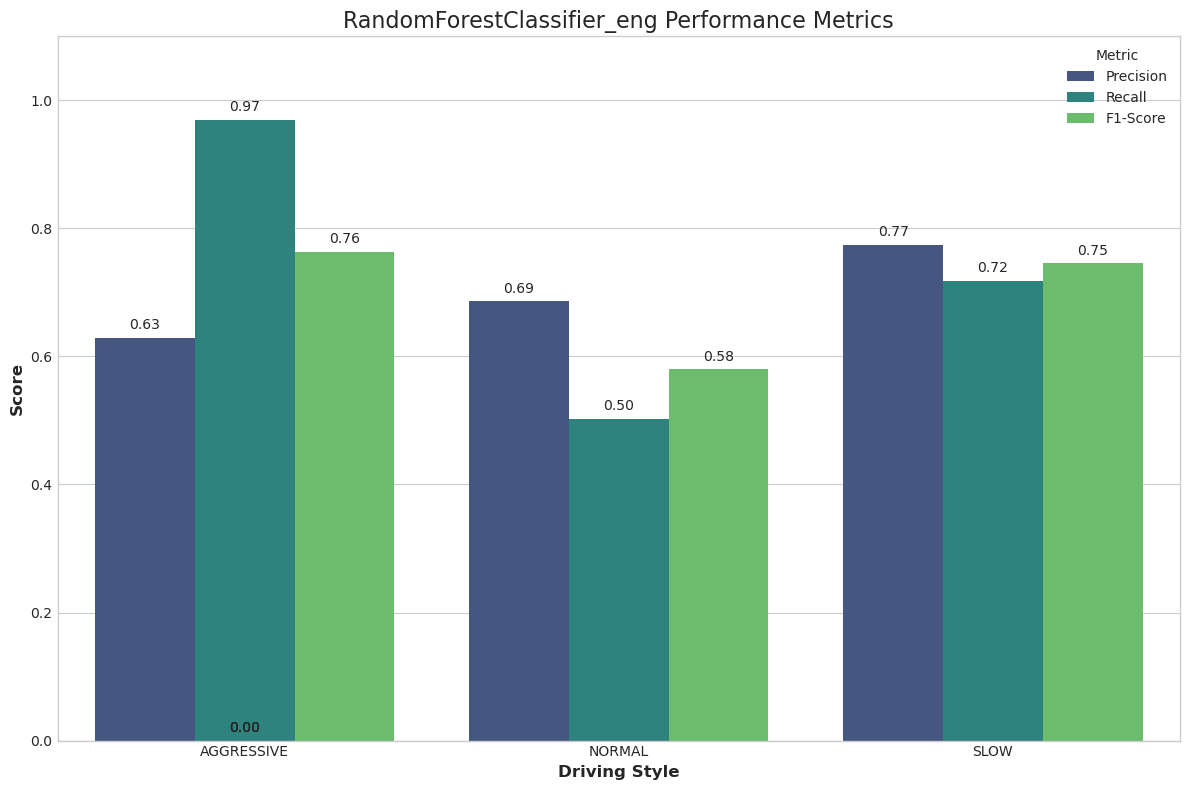

In [ ]:
le = LabelEncoder()
le.fit(['AGGRESSIVE', 'NORMAL', 'SLOW'])
class_names = le.classes_


best_model_report = results.get('RandomForestClassifier_eng')

plot_data = []
for class_idx, class_name in enumerate(class_names):
    report_class = best_model_report.get(str(class_idx), {})
    plot_data.append({'class': class_name, 'score_type': 'Precision', 'score': report_class.get('precision', 0)})
    plot_data.append({'class': class_name, 'score_type': 'Recall', 'score': report_class.get('recall', 0)})
    plot_data.append({'class': class_name, 'score_type': 'F1-Score', 'score': report_class.get('f1-score', 0)})

plot_df = pd.DataFrame(plot_data)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(x='class', y='score', hue='score_type', data=plot_df, palette='viridis', ax=ax)

ax.set_xlabel('Driving Style', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('RandomForestClassifier_eng Performance Metrics', fontsize=16, fontweight='normal')
ax.set_ylim(0, 1.1)
ax.legend(title='Metric')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.tight_layout()
plt.show()
